In [211]:
from transformers import pipeline

triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')
# We need to use the tokenizer manually since we need special tokens.
extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor("Punta Cana is a resort town in the municipality of Higuey, in La Altagracia Province, the eastern most province of the Dominican Republic", return_tensors=True, return_text=False)[0]["generated_token_ids"]])

print(extracted_text[0])
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets
extracted_triplets = extract_triplets(extracted_text[0])
print(extracted_triplets)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higuey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s>
[{'head': 'Punta Cana', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Punta Cana', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Higuey', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higuey', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'La Altagracia Province', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Dominican Republic', 'type': 'contains administrative 

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.11/site-packages/transformers/pi

In [72]:
import re

with open("data/dracula.txt") as f:
    text = f.read()

paragraphs = re.split(r'[\n]{2,}', text)
len(paragraphs)

lines = []
for p in paragraphs:
    lines.extend(re.split(r'[\n]{1,}', p))

print(len(lines))

13381


In [100]:
entities = {}
for i, line in enumerate(lines):
    if (i % 1000 == 0):
        print(f"Processed: {i} lines")
    
    results = nlp(line)
    for result in results:
        word = line[result["start"]:result["end"]]
        entity_group = result["entity_group"]
        score = result["score"]
        
        if entity_group == "PER":
            dummy = {}
            dummy.setdefault("score", 0)
            dummy.setdefault("count", 0)
            
            entities.setdefault(word, dummy)
            entry = entities[word]
            
            if score > entry["score"]:
                entry["score"] = round(score, 3)
                entry["type"] = entity_group
                entry["count"] += 1
    
                entities[word] = entry

len(entities)

Processed: 0 lines
Processed: 1000 lines
Processed: 2000 lines
Processed: 3000 lines
Processed: 4000 lines
Processed: 5000 lines
Processed: 6000 lines
Processed: 7000 lines
Processed: 8000 lines
Processed: 9000 lines
Processed: 10000 lines
Processed: 11000 lines
Processed: 12000 lines
Processed: 13000 lines


322

In [120]:
describe_dict(entities)

{'Gabriel': {'score': 0.999, 'count': 1, 'type': 'PER'},
 'Mitchell': {'score': 0.998, 'count': 1, 'type': 'PER'},
 'Op': {'score': 0.972, 'count': 1, 'type': 'PER'},
 'Judge Moneybag': {'score': 0.965, 'count': 1, 'type': 'PER'},
 'Charc': {'score': 0.767, 'count': 1, 'type': 'PER'}}

In [216]:
import random

MIN_LEN = 1
MIN_SCORE = 0.995
MIN_COUNT = 2

def describe_dict(d, n = 5):
    keys = []
    for i in range(0, n):
        keys.append(random.choice(list(d.keys())))

    desc = dict([(k, d[k]) for k in keys])
    return desc

def entity_filter(pair):
    key, value = pair

    return (
        len(key) > MIN_LEN and 
        value["score"] >= MIN_SCORE and 
        value["count"] > MIN_COUNT
    )

def filter_entities(entities):
    return dict(filter(entity_filter, entities.items()))

filtered_entities = filter_entities(entities)
describe_dict(filtered_entities)

{'Sam': {'score': 0.999, 'count': 3, 'type': 'PER'},
 'Mina': {'score': 0.997, 'count': 7, 'type': 'PER'},
 'Arthur': {'score': 0.999, 'count': 4, 'type': 'PER'},
 'Devil': {'score': 0.995, 'count': 3, 'type': 'PER'},
 'Art': {'score': 0.998, 'count': 4, 'type': 'PER'}}

In [217]:
len(filtered_entities)

24

In [218]:
def entities_to_graph(entities):
    nodes = [(k, v) for (k,v) in entities.items()]
    edges = []

    node_labels = {f"{k}": f"{k}" for k in entities}
    edge_labels = {}

    return (
        nodes,
        edges,
        node_labels,
        edge_labels
    )

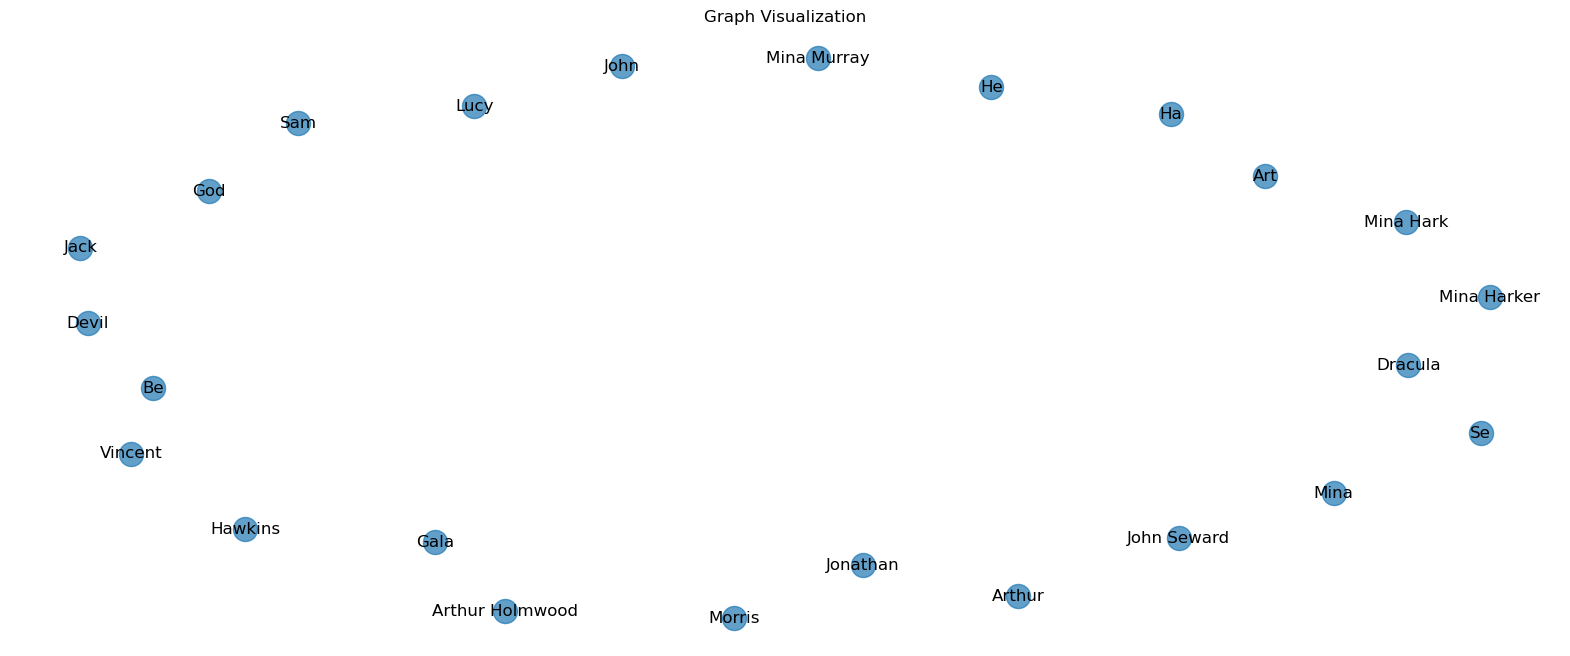

In [220]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(nodes, edges, node_labels=None, edge_labels=None, title="Graph Visualization"):
    """
    Visualize a graph using NetworkX and Matplotlib.
    
    Parameters:
    nodes: list of nodes
    edges: list of tuples representing edges (source, target)
    node_labels: dict of node labels (optional)
    edge_labels: dict of edge labels (optional)
    title: string for graph title
    """
    # Create a new graph
    G = nx.Graph()
    
    # Add nodes and edges
    G.add_nodes_from(nodes)
    # G.add_edges_from(edges)
    
    # Create a figure with a reasonable size
    plt.figure(figsize=(20, 8))
    
    # Set the layout for the graph
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color='gray', 
                          width=1, alpha=0.5)
    
    # Add node labels if provided
    if node_labels is None:
        node_labels = {node: str(node) for node in nodes}
    nx.draw_networkx_labels(G, pos, node_labels)
    
    # Add edge labels if provided
    if edge_labels is not None:
        nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    # Add title and remove axes
    plt.title(title)
    plt.axis('off')
    
    # Show the plot
    plt.show()

(nodes, edges, node_labels, edge_labels) = entities_to_graph(filtered_entities)
visualize_graph(nodes, edges, node_labels, edge_labels)